In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

# Загрузка уменьшенного датасета
try:
    from tensorflow.keras.datasets import mnist
    print("Using Keras to load MNIST...")
    (train_images, train_labels), (test_images, test_labels) = mnist.load_data()

    # Берем только маленькое подмножество для быстрого тестирования
    train_size = 5000  # Уменьшаем в 12 раз
    test_size = 1000   # Уменьшаем в 10 раз

    train_images = train_images[:train_size].reshape(-1, 28, 28, 1).astype(np.float32) / 255.0
    train_labels = train_labels[:train_size]
    test_images = test_images[:test_size].reshape(-1, 28, 28, 1).astype(np.float32) / 255.0
    test_labels = test_labels[:test_size]

    print("Reduced MNIST loaded successfully!")

except ImportError:
    print("Creating small synthetic dataset...")
    # Создаем очень маленький синтетический датасет
    train_size = 3000
    test_size = 600

    train_images = np.random.rand(train_size, 28, 28, 1).astype(np.float32) * 0.3
    train_labels = np.random.randint(0, 10, train_size)

    # Добавляем простые паттерны
    for i in range(train_size):
        label = train_labels[i]
        center_x, center_y = np.random.randint(8, 20), np.random.randint(8, 20)
        size = np.random.randint(2, 5)

        # Простой паттерн - квадрат
        train_images[i, center_y-size:center_y+size, center_x-size:center_x+size, 0] += 0.7

    test_images = np.random.rand(test_size, 28, 28, 1).astype(np.float32) * 0.3
    test_labels = np.random.randint(0, 10, test_size)

    for i in range(test_size):
        label = test_labels[i]
        center_x, center_y = np.random.randint(8, 20), np.random.randint(8, 20)
        size = np.random.randint(2, 5)
        test_images[i, center_y-size:center_y+size, center_x-size:center_x+size, 0] += 0.7

print(f"Training data shape: {train_images.shape}")
print(f"Training labels shape: {train_labels.shape}")
print(f"Test data shape: {test_images.shape}")
print(f"Test labels shape: {test_labels.shape}")

# One-hot encoding
encoder = OneHotEncoder(sparse_output=False)
train_labels_onehot = encoder.fit_transform(train_labels.reshape(-1, 1))
test_labels_onehot = encoder.transform(test_labels.reshape(-1, 1))

print("Data preparation completed!")

Using Keras to load MNIST...
Reduced MNIST loaded successfully!
Training data shape: (5000, 28, 28, 1)
Training labels shape: (5000,)
Test data shape: (1000, 28, 28, 1)
Test labels shape: (1000,)
Data preparation completed!


In [ ]:
class ActivationFunctions:
    @staticmethod
    def relu(x):
        return np.maximum(0, x)

    @staticmethod
    def relu_derivative(x):
        return (x > 0).astype(np.float32)

    @staticmethod
    def softmax(x):
        # Улучшенная стабилизация
        x_stable = x - np.max(x, axis=1, keepdims=True)
        exp_x = np.exp(x_stable)
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

class LossFunctions:
    @staticmethod
    def cross_entropy(y_pred, y_true):
        # Улучшенная стабилизация
        epsilon = 1e-8
        y_pred = np.clip(y_pred, epsilon, 1. - epsilon)
        return -np.mean(np.sum(y_true * np.log(y_pred), axis=1))

    @staticmethod
    def cross_entropy_derivative(y_pred, y_true):
        # Прямая производная для softmax + cross_entropy
        return (y_pred - y_true) / y_true.shape[0]  # Нормализация по размеру батча

class ConvOperations:
    @staticmethod
    def convolve2d(image, kernel, padding=1, stride=1):
        """Оптимизированная 2D свертка"""
        batch_size, h, w, channels = image.shape
        kernel_h, kernel_w, in_channels, out_channels = kernel.shape

        # Вычисляем размеры выходного изображения
        output_h = (h + 2 * padding - kernel_h) // stride + 1
        output_w = (w + 2 * padding - kernel_w) // stride + 1

        # Добавляем padding
        if padding > 0:
            image_padded = np.pad(image, ((0, 0), (padding, padding), (padding, padding), (0, 0)), mode='constant')
        else:
            image_padded = image

        # Инициализируем выход
        output = np.zeros((batch_size, output_h, output_w, out_channels))

        # Оптимизированная свертка
        for i in range(output_h):
            h_start = i * stride
            h_end = h_start + kernel_h
            for j in range(output_w):
                w_start = j * stride
                w_end = w_start + kernel_w

                patch = image_padded[:, h_start:h_end, w_start:w_end, :]

                # Векторизованное вычисление для всех выходных каналов
                for k in range(out_channels):
                    output[:, i, j, k] = np.sum(patch * kernel[:, :, :, k], axis=(1, 2, 3))

        return output

    @staticmethod
    def convolve_backward(d_output, input_map, kernel, padding=1, stride=1):
        """Оптимизированное обратное распространение"""
        batch_size, h, w, channels = input_map.shape
        kernel_h, kernel_w, in_channels, out_channels = kernel.shape

        # Добавляем padding
        if padding > 0:
            input_padded = np.pad(input_map, ((0, 0), (padding, padding), (padding, padding), (0, 0)), mode='constant')
        else:
            input_padded = input_map

        d_kernel = np.zeros_like(kernel)
        d_input = np.zeros_like(input_padded)

        output_h, output_w = d_output.shape[1], d_output.shape[2]

        for i in range(output_h):
            for j in range(output_w):
                h_start = i * stride
                h_end = h_start + kernel_h
                w_start = j * stride
                w_end = w_start + kernel_w

                patch = input_padded[:, h_start:h_end, w_start:w_end, :]

                for k in range(out_channels):
                    # Градиент для ядра с ограничением значений
                    grad_update = np.sum(patch * d_output[:, i:i+1, j:j+1, k:k+1], axis=0)
                    d_kernel[:, :, :, k] += np.clip(grad_update, -1e3, 1e3)  # Защита от переполнения

                    # Градиент для входной карты с ограничением значений
                    input_update = kernel[:, :, :, k] * d_output[:, i:i+1, j:j+1, k:k+1]
                    d_input[:, h_start:h_end, w_start:w_end, :] += np.clip(input_update, -1e3, 1e3)

        # Убираем padding
        if padding > 0:
            d_input = d_input[:, padding:-padding
                              , padding:-padding, :]

        return d_input, d_kernel

In [ ]:
class Conv2D:
    def __init__(self, input_channels, output_channels, kernel_size=3, padding=1, stride=1):
        self.kernel_size = kernel_size
        self.output_channels = output_channels
        self.input_channels = input_channels
        self.padding = padding
        self.stride = stride

        # Консервативная инициализация
        scale = np.sqrt(1.0 / (kernel_size * kernel_size * input_channels))
        self.kernel = np.random.randn(kernel_size, kernel_size, input_channels, output_channels) * scale
        self.bias = np.zeros(output_channels)

        self.input = None
        self.output = None

    def forward(self, x):
        self.input = x
        output = ConvOperations.convolve2d(x, self.kernel, self.padding, self.stride)
        output += self.bias
        self.output = ActivationFunctions.relu(output)
        return self.output

    def backward(self, d_output, learning_rate):
        # Производная ReLU
        d_output = d_output * ActivationFunctions.relu_derivative(self.output)

        d_input, d_kernel = ConvOperations.convolve_backward(d_output, self.input, self.kernel, self.padding, self.stride)
        d_bias = np.sum(d_output, axis=(0, 1, 2))

        # Ограничение градиентов
        d_kernel = np.clip(d_kernel, -1.0, 1.0)
        d_bias = np.clip(d_bias, -1.0, 1.0)

        self.kernel -= learning_rate * d_kernel
        self.bias -= learning_rate * d_bias

        return d_input

class MaxPool2D:
    def __init__(self, pool_size=2, stride=2):
        self.pool_size = pool_size
        self.stride = stride
        self.input = None
        self.output = None

    def forward(self, x):
        self.input = x
        batch_size, h, w, channels = x.shape

        output_h = h // self.stride
        output_w = w // self.stride

        output = np.zeros((batch_size, output_h, output_w, channels))

        for i in range(output_h):
            for j in range(output_w):
                h_start = i * self.stride
                h_end = h_start + self.pool_size
                w_start = j * self.stride
                w_end = w_start + self.pool_size

                patch = x[:, h_start:h_end, w_start:w_end, :]
                output[:, i, j, :] = np.max(patch, axis=(1, 2))

        self.output = output
        return output

    def backward(self, d_output):
        batch_size, h, w, channels = self.input.shape
        d_input = np.zeros_like(self.input)

        output_h, output_w = d_output.shape[1], d_output.shape[2]

        for i in range(output_h):
            for j in range(output_w):
                h_start = i * self.stride
                h_end = h_start + self.pool_size
                w_start = j * self.stride
                w_end = w_start + self.pool_size

                patch = self.input[:, h_start:h_end, w_start:w_end, :]

                for b in range(batch_size):
                    for c in range(channels):
                        max_idx = np.unravel_index(np.argmax(patch[b, :, :, c]), (self.pool_size, self.pool_size))
                        d_input[b, h_start + max_idx[0], w_start + max_idx[1], c] += d_output[b, i, j, c]

        return d_input

class Flatten:
    def __init__(self):
        self.input_shape = None

    def forward(self, x):
        self.input_shape = x.shape
        return x.reshape(x.shape[0], -1)

    def backward(self, d_output):
        return d_output.reshape(self.input_shape)

class Dense:
    def __init__(self, input_size, output_size, activation=None):
        self.input_size = input_size
        self.output_size = output_size
        self.activation = activation

        # Инициализация
        scale = np.sqrt(2.0 / input_size)
        self.weights = np.random.randn(input_size, output_size) * scale
        self.bias = np.zeros(output_size)
        self.input = None
        self.output = None

    def forward(self, x):
        self.input = x
        self.output = np.dot(x, self.weights) + self.bias

        if self.activation == 'relu':
            return ActivationFunctions.relu(self.output)
        elif self.activation == 'softmax':
            return ActivationFunctions.softmax(self.output)
        else:
            return self.output

    def backward(self, d_output, learning_rate):
        if self.activation == 'relu':
            d_output = d_output * ActivationFunctions.relu_derivative(self.output)

        d_input = np.dot(d_output, self.weights.T)
        d_weights = np.dot(self.input.T, d_output)
        d_bias = np.sum(d_output, axis=0)

        # Ограничение градиентов
        d_weights = np.clip(d_weights, -1.0, 1.0)
        d_bias = np.clip(d_bias, -1.0, 1.0)

        self.weights -= learning_rate * d_weights
        self.bias -= learning_rate * d_bias

        return d_input

In [ ]:
class SimpleCNN:
    def __init__(self):
        # Упрощенная архитектура с правильными размерами
        self.conv1 = Conv2D(input_channels=1, output_channels=4, kernel_size=3)  # Еще меньше каналов
        self.pool1 = MaxPool2D(pool_size=2, stride=2)
        self.conv2 = Conv2D(input_channels=4, output_channels=8, kernel_size=3)
        self.pool2 = MaxPool2D(pool_size=2, stride=2)
        self.flatten = Flatten()

        # Правильные размеры после сверточных слоев: (28x28) -> pool(2) -> (14x14) -> pool(2) -> (7x7)
        # 7 * 7 * 8 = 392
        self.dense1 = Dense(7 * 7 * 8, 32, activation='relu')  # Правильный размер
        self.dense2 = Dense(32, 10)  # Без активации - softmax применяется отдельно

        self.history = {
            'train_loss': [], 'train_accuracy': [],
            'val_loss': [], 'val_accuracy': []
        }

    def forward(self, x, training=True):
        # Сверточные слои
        x = self.conv1.forward(x)
        x = self.pool1.forward(x)
        x = self.conv2.forward(x)
        x = self.pool2.forward(x)

        # Полносвязные слои
        x = self.flatten.forward(x)
        x = self.dense1.forward(x)  # Здесь уже применяется ReLU
        x = self.dense2.forward(x)  # Без активации

        # Softmax применяется в конце
        return ActivationFunctions.softmax(x)

    def backward(self, d_output, learning_rate):
        # Обратное распространение через полносвязные слои
        d_output = self.dense2.backward(d_output, learning_rate)
        d_output = self.dense1.backward(d_output, learning_rate)

        # Обратное распространение через сверточные слои
        d_output = self.flatten.backward(d_output)
        d_output = self.pool2.backward(d_output)
        d_output = self.conv2.backward(d_output, learning_rate)
        d_output = self.pool1.backward(d_output)
        d_output = self.conv1.backward(d_output, learning_rate)

    def train(self, x_train, y_train, x_val, y_val, epochs=3, batch_size=32, learning_rate=0.01):
        print("Starting training...")

        for epoch in range(epochs):
            # Простое обучение без перемешивания для скорости
            train_loss = 0
            train_correct = 0
            num_batches = 0

            for i in range(0, len(x_train), batch_size):
                x_batch = x_train[i:i+batch_size]
                y_batch = y_train[i:i+batch_size]

                # Прямое распространение
                output = self.forward(x_batch)
                loss = LossFunctions.cross_entropy(output, y_batch)
                predictions = np.argmax(output, axis=1)
                true_labels = np.argmax(y_batch, axis=1)
                correct = np.sum(predictions == true_labels)

                train_loss += loss
                train_correct += correct
                num_batches += 1

                # Обратное распространение
                d_output = LossFunctions.cross_entropy_derivative(output, y_batch)
                self.backward(d_output, learning_rate)

            # Валидация
            val_output = self.forward(x_val)
            val_loss = LossFunctions.cross_entropy(val_output, y_val)
            val_predictions = np.argmax(val_output, axis=1)
            val_true = np.argmax(y_val, axis=1)
            val_accuracy = np.mean(val_predictions == val_true)

            avg_train_loss = train_loss / num_batches
            avg_train_accuracy = train_correct / len(x_train)

            self.history['train_loss'].append(avg_train_loss)
            self.history['train_accuracy'].append(avg_train_accuracy)
            self.history['val_loss'].append(val_loss)
            self.history['val_accuracy'].append(val_accuracy)

            print(f"Epoch {epoch+1}/{epochs}:")
            print(f"  Train Loss: {avg_train_loss:.4f}, Train Accuracy: {avg_train_accuracy:.4f}")
            print(f"  Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

    def evaluate(self, x, y):
        output = self.forward(x)
        loss = LossFunctions.cross_entropy(output, y)
        predictions = np.argmax(output, axis=1)
        true_labels = np.argmax(y, axis=1)
        accuracy = np.mean(predictions == true_labels)
        return loss, accuracy

    def predict(self, x):
        return self.forward(x)

In [ ]:
print("Creating fixed CNN model...")
model = SimpleCNN()

print("Testing forward pass with one batch...")
test_batch = train_images[:2]
test_output = model.forward(test_batch)
print(f"Input shape: {test_batch.shape}")
print(f"Output shape: {test_output.shape}")
print(f"Output sum (should be ~1.0): {np.sum(test_output[0]):.4f}")

x_val = train_images[:500]
y_val = train_labels_onehot[:500]
x_train = train_images[500:2000]
y_train = train_labels_onehot[500:2000]

print(f"Training set: {x_train.shape[0]} samples")
print(f"Validation set: {x_val.shape[0]} samples")

epochs = 10
batch_size = 32
learning_rate = 0.005

print("Starting training...")
model.train(x_train, y_train, x_val, y_val,
            epochs=epochs, batch_size=batch_size, learning_rate=learning_rate)

print("Training completed!")

Creating fixed CNN model...
Testing forward pass with one batch...
Input shape: (2, 28, 28, 1)
Output shape: (2, 10)
Output sum (should be ~1.0): 1.0000
Training set: 1500 samples
Validation set: 500 samples
Starting training...
Starting training...
Epoch 1/10:
  Train Loss: 2.2658, Train Accuracy: 0.1680
  Val Loss: 2.1885, Val Accuracy: 0.2100
Epoch 2/10:
  Train Loss: 2.1305, Train Accuracy: 0.2740
  Val Loss: 2.0685, Val Accuracy: 0.3140
Epoch 3/10:
  Train Loss: 2.0070, Train Accuracy: 0.3580
  Val Loss: 1.9241, Val Accuracy: 0.4220
Epoch 4/10:
  Train Loss: 1.8458, Train Accuracy: 0.4687
  Val Loss: 1.7273, Val Accuracy: 0.5340
Epoch 5/10:
  Train Loss: 1.6354, Train Accuracy: 0.5640
  Val Loss: 1.4756, Val Accuracy: 0.6160
Epoch 6/10:
  Train Loss: 1.3860, Train Accuracy: 0.6447
  Val Loss: 1.2074, Val Accuracy: 0.6920
Epoch 7/10:
  Train Loss: 1.1369, Train Accuracy: 0.7233
  Val Loss: 0.9716, Val Accuracy: 0.7660
Epoch 8/10:
  Train Loss: 0.9339, Train Accuracy: 0.7573
  Val L


Evaluating on test set...
Test Loss: 0.7702
Test Accuracy: 0.7660


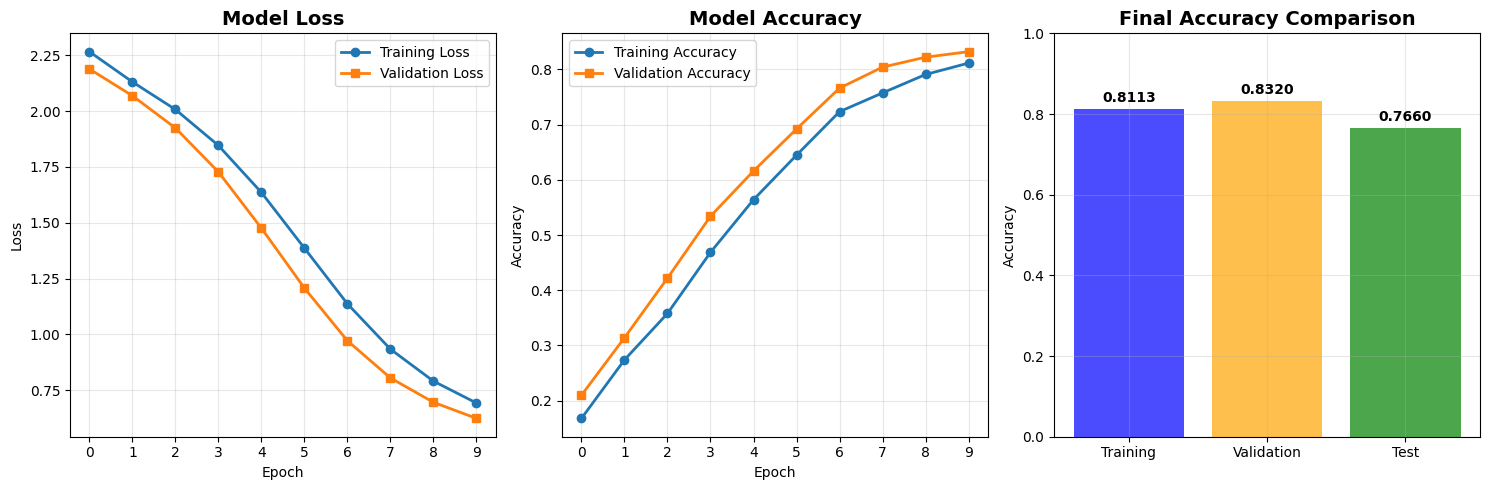


FINAL TRAINING RESULTS
Metric                    Training     Validation   Test        
------------------------------------------------------------
Final Accuracy            0.8113       0.8320       0.7660
Final Loss                0.6929       0.6242       0.7702
Best Accuracy             0.8113       0.8320       0.7660
------------------------------------------------------------
Accuracy Improvement      0.6433
Training Epochs           10

Model Architecture:
  Conv1: 1 → 4 channels (3x3)
  Pool1: 2x2 MaxPool
  Conv2: 4 → 8 channels (3x3)
  Pool2: 2x2 MaxPool
  Dense1: 392 → 32 (ReLU)
  Dense2: 32 → 10 (Softmax)


In [ ]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(model.history['train_loss'], label='Training Loss', marker='o', linewidth=2)
plt.plot(model.history['val_loss'], label='Validation Loss', marker='s', linewidth=2)
plt.title('Model Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(range(len(model.history['train_loss'])))

plt.subplot(1, 3, 2)
plt.plot(model.history['train_accuracy'], label='Training Accuracy', marker='o', linewidth=2)
plt.plot(model.history['val_accuracy'], label='Validation Accuracy', marker='s', linewidth=2)
plt.title('Model Accuracy', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(range(len(model.history['train_accuracy'])))

print("\nEvaluating on test set...")
test_loss, test_accuracy = model.evaluate(test_images[:500], test_labels_onehot[:500])
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

plt.subplot(1, 3, 3)
metrics = ['Training', 'Validation', 'Test']
accuracy_values = [
    model.history['train_accuracy'][-1],
    model.history['val_accuracy'][-1],
    test_accuracy
]

bars = plt.bar(metrics, accuracy_values, color=['blue', 'orange', 'green'], alpha=0.7)
plt.title('Final Accuracy Comparison', fontsize=14, fontweight='bold')
plt.ylabel('Accuracy')
plt.ylim(0, 1.0)

for bar, value in zip(bars, accuracy_values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{value:.4f}', ha='center', va='bottom', fontweight='bold')

plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("FINAL TRAINING RESULTS")
print("="*60)
print(f"{'Metric':<25} {'Training':<12} {'Validation':<12} {'Test':<12}")
print("-"*60)
print(f"{'Final Accuracy':<25} {model.history['train_accuracy'][-1]:.4f}       {model.history['val_accuracy'][-1]:.4f}       {test_accuracy:.4f}")
print(f"{'Final Loss':<25} {model.history['train_loss'][-1]:.4f}       {model.history['val_loss'][-1]:.4f}       {test_loss:.4f}")
print(f"{'Best Accuracy':<25} {max(model.history['train_accuracy']):.4f}       {max(model.history['val_accuracy']):.4f}       {test_accuracy:.4f}")
print("-"*60)
print(f"{'Accuracy Improvement':<25} {model.history['train_accuracy'][-1] - model.history['train_accuracy'][0]:.4f}")
print(f"{'Training Epochs':<25} {len(model.history['train_loss'])}")
print("="*60)

print("\nModel Architecture:")
print("  Conv1: 1 → 4 channels (3x3)")
print("  Pool1: 2x2 MaxPool")
print("  Conv2: 4 → 8 channels (3x3)")
print("  Pool2: 2x2 MaxPool")
print("  Dense1: 392 → 32 (ReLU)")
print("  Dense2: 32 → 10 (Softmax)")